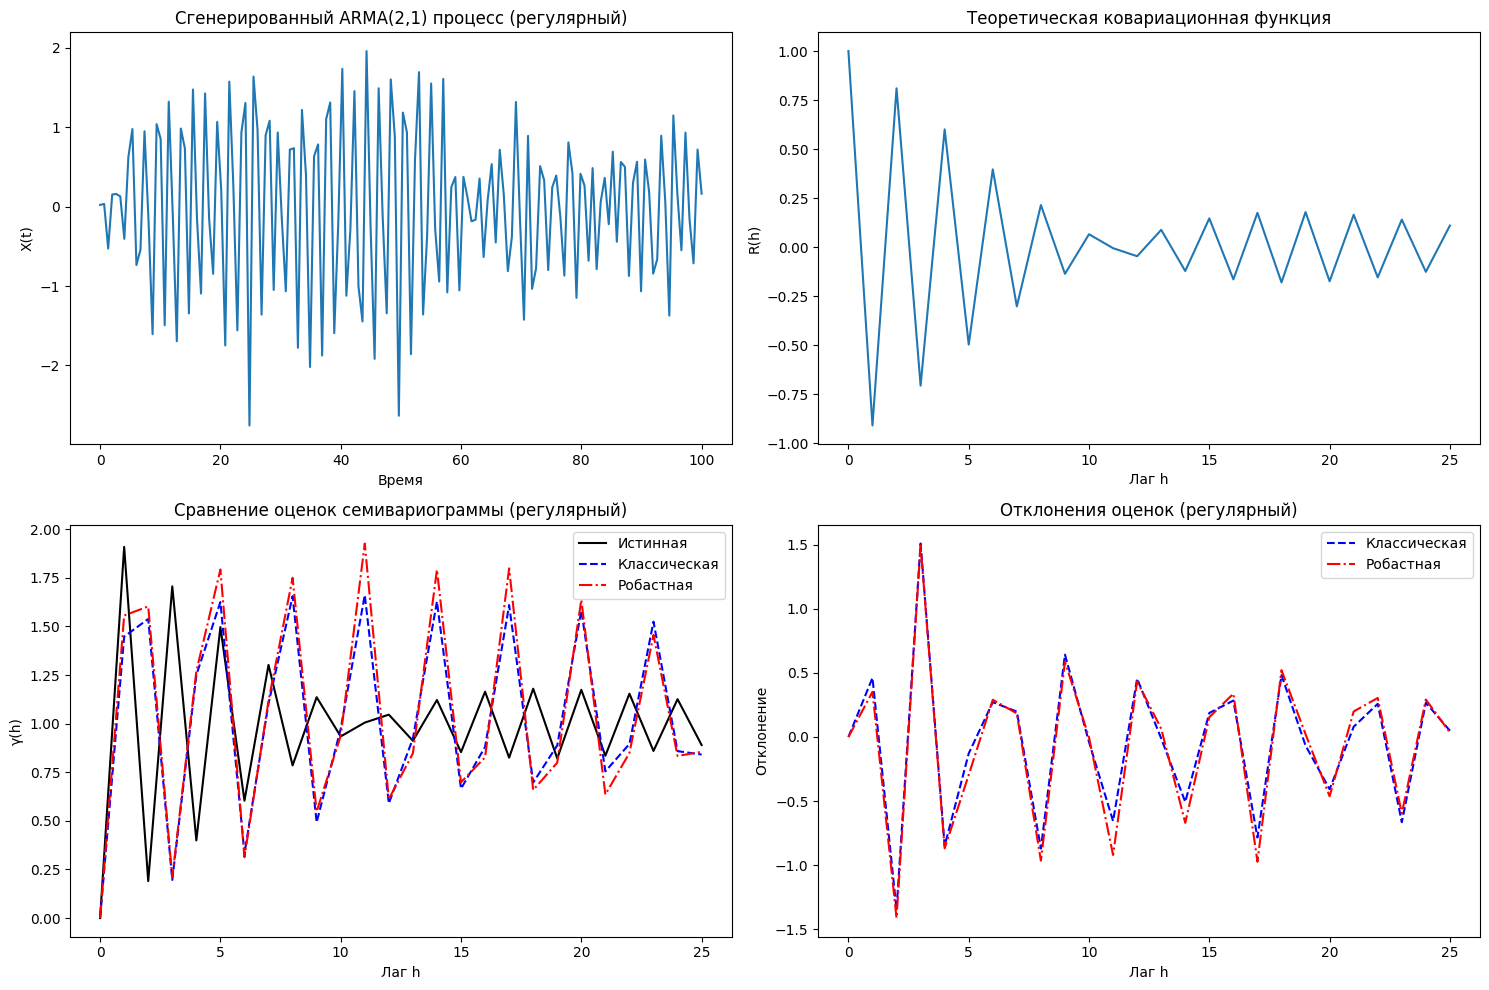

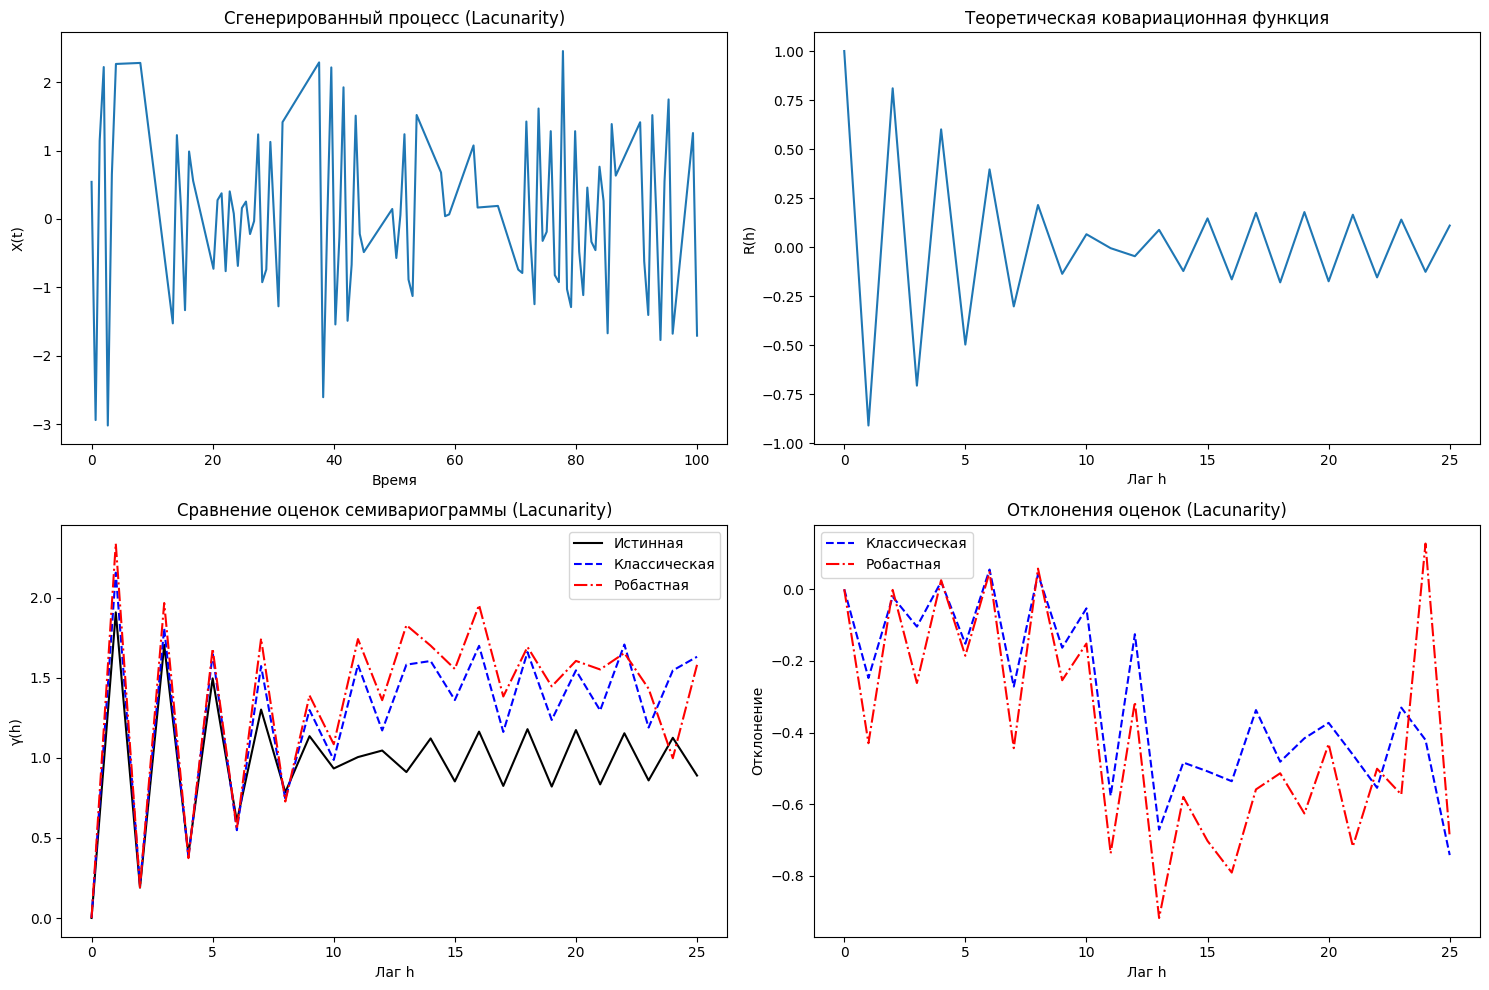

In [2]:
#первая часть общая
import numpy as np
import matplotlib.pyplot as plt

# Общие теоретические функции
def theoretical_cov(h, D=1.0, alpha=0.15, beta=3.0):
    return D * np.exp(-alpha*np.abs(h)) * np.cos(beta*h)

def true_semivariogram(h, D=1.0, alpha=0.15, beta=3.0):
    return D * (1 - np.exp(-alpha*np.abs(h)) * np.cos(beta*h))

# Функции для регулярного случая
def generate_arma_process(n=150, T=100.0, D=1.0, alpha=0.15, beta=3.0):
    dt = T / n
    gamma = alpha * dt
    gamma0 = beta * dt

    alpha_0 = np.exp(-gamma) * (np.exp(-2*gamma) - 1) * np.cos(gamma0)
    alpha1 = 1 - np.exp(-4*gamma)

    a0 = np.sqrt(D) * alpha
    a1 = np.sqrt(D) * (alpha_0 / alpha)
    b1 = 2 * np.exp(-gamma) * np.cos(gamma0)
    b2 = -np.exp(-2 * gamma)

    np.random.seed(43)
    x = np.random.normal(0, 1, n)

    xi = np.zeros(n)
    xi[0] = a0 * x[0]
    xi[1] = a0 * x[1] + a1 * x[0] + b1 * xi[0]

    for k in range(2, n):
        xi[k] = a0 * x[k] + a1 * x[k-1] + b1 * xi[k-1] + b2 * xi[k-2]

    return xi

def classical_semivariogram_estimate(X, h_max):
    n = len(X)
    gamma_hat = np.zeros(h_max + 1)
    
    for h in range(h_max + 1):
        if h < n:
            diffs = (X[h:] - X[:n-h])**2
            gamma_hat[h] = np.sum(diffs) / (2 * (n - h))
        else:
            gamma_hat[h] = 0
    
    return gamma_hat

def robust_semivariogram_estimate(X, h_max):
    n = len(X)
    gamma_hat_rob = np.zeros(h_max + 1)
    
    for h in range(h_max + 1):
        if h < n:
            abs_diffs = np.abs(X[h:] - X[:n-h])
            term1 = np.mean(abs_diffs**0.5)
            denominator = 2 * (0.457 + 0.494/(n-h) + 0.045/(n-h)**2)
            gamma_hat_rob[h] = (term1**4) / denominator
        else:
            gamma_hat_rob[h] = 0
    
    return gamma_hat_rob

# Функции для случая с Lacunarity
def add_lacunarity(t_regular, n_gaps=5, gap_size=0.1):
    t_irregular = t_regular.copy()
    total_time = t_regular[-1] - t_regular[0]
    gap_size_abs = gap_size * total_time
    
    for _ in range(n_gaps):
        gap_start = np.random.uniform(t_irregular[0], t_irregular[-1] - gap_size_abs)
        mask = (t_irregular < gap_start) | (t_irregular > gap_start + gap_size_abs)
        t_irregular = t_irregular[mask]
    
    return t_irregular

def generate_gaussian_process(t_points, D=1.0, alpha=0.15, beta=3.0):
    n = len(t_points)
    cov_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            cov_matrix[i, j] = theoretical_cov(t_points[i] - t_points[j], D, alpha, beta)
    
    return np.random.multivariate_normal(np.zeros(n), cov_matrix)

def irregular_semivariogram(t, X, h_max, method='classical'):
    n = len(X)
    gamma = np.zeros(h_max + 1)
    counts = np.zeros(h_max + 1)
    
    for i in range(n):
        for j in range(i + 1, n):
            h = int(np.round(np.abs(t[i] - t[j])))
            if h <= h_max:
                if method == 'classical':
                    gamma[h] += (X[i] - X[j])**2
                elif method == 'robust':
                    gamma[h] += np.abs(X[i] - X[j])**0.5
                counts[h] += 1
    
    if method == 'classical':
        with np.errstate(divide='ignore', invalid='ignore'):
            gamma = np.where(counts > 0, gamma / (2 * counts), 0)
    elif method == 'robust':
        for h in range(h_max + 1):
            if counts[h] > 0:
                term = gamma[h] / counts[h]
                denominator = 2 * (0.457 + 0.494/counts[h] + 0.045/counts[h]**2)
                gamma[h] = (term**4) / denominator
            else:
                gamma[h] = 0
    return gamma

# Параметры моделирования
np.random.seed(42)
D = 1.0
alpha = 0.085
beta = 3.0
T = 100.0
n = 150
h_max = 25
n_gaps = 15
gap_size = 0.03

# 1. Регулярный случай
t_regular = np.linspace(0, T, n)
X_regular = generate_arma_process(n, T, D, alpha, beta)

# 2. Случай с Lacunarity
t_irregular = add_lacunarity(t_regular, n_gaps, gap_size)
X_irregular = generate_gaussian_process(t_irregular, D, alpha, beta)

# Общие вычисления
h_values = np.arange(h_max + 1)
true_gamma = np.array([true_semivariogram(h, D, alpha, beta) for h in h_values])

# Визуализация регулярного случая
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(np.linspace(0, T, n), X_regular)
plt.title('Сгенерированный ARMA(2,1) процесс (регулярный)')
plt.xlabel('Время')
plt.ylabel('X(t)')

plt.subplot(2, 2, 2)
cov_values = [theoretical_cov(h, D, alpha, beta) for h in h_values]
plt.plot(h_values, cov_values)
plt.title('Теоретическая ковариационная функция')
plt.xlabel('Лаг h')
plt.ylabel('R(h)')

gamma_reg_classic = classical_semivariogram_estimate(X_regular, h_max)
gamma_reg_robust = robust_semivariogram_estimate(X_regular, h_max)

plt.subplot(2, 2, 3)
plt.plot(h_values, true_gamma, 'k-', label='Истинная')
plt.plot(h_values, gamma_reg_classic, 'b--', label='Классическая')
plt.plot(h_values, gamma_reg_robust, 'r-.', label='Робастная')
plt.title('Сравнение оценок семивариограммы (регулярный)')
plt.xlabel('Лаг h')
plt.ylabel('γ(h)')
plt.legend()

deviation_classic = np.array(true_gamma) - gamma_reg_classic
deviation_robust = np.array(true_gamma) - gamma_reg_robust

plt.subplot(2, 2, 4)
plt.plot(h_values, deviation_classic, 'b--', label='Классическая')
plt.plot(h_values, deviation_robust, 'r-.', label='Робастная')
plt.title('Отклонения оценок (регулярный)')
plt.xlabel('Лаг h')
plt.ylabel('Отклонение')
plt.legend()

plt.tight_layout()
plt.show()

# Визуализация случая с Lacunarity
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(t_irregular, X_irregular)
plt.title('Сгенерированный процесс (Lacunarity)')
plt.xlabel('Время')
plt.ylabel('X(t)')

plt.subplot(2, 2, 2)
plt.plot(h_values, cov_values)
plt.title('Теоретическая ковариационная функция')
plt.xlabel('Лаг h')
plt.ylabel('R(h)')

gamma_irreg_classic = irregular_semivariogram(t_irregular, X_irregular, h_max, 'classical')
gamma_irreg_robust = irregular_semivariogram(t_irregular, X_irregular, h_max, 'robust')

plt.subplot(2, 2, 3)
plt.plot(h_values, true_gamma, 'k-', label='Истинная')
plt.plot(h_values, gamma_irreg_classic, 'b--', label='Классическая')
plt.plot(h_values, gamma_irreg_robust, 'r-.', label='Робастная')
plt.title('Сравнение оценок семивариограммы (Lacunarity)')
plt.xlabel('Лаг h')
plt.ylabel('γ(h)')
plt.legend()

deviation_irreg_classic = np.array(true_gamma) - gamma_irreg_classic
deviation_irreg_robust = np.array(true_gamma) - gamma_irreg_robust

plt.subplot(2, 2, 4)
plt.plot(h_values, deviation_irreg_classic, 'b--', label='Классическая')
plt.plot(h_values, deviation_irreg_robust, 'r-.', label='Робастная')
plt.title('Отклонения оценок (Lacunarity)')
plt.xlabel('Лаг h')
plt.ylabel('Отклонение')
plt.legend()

plt.tight_layout()
plt.show()

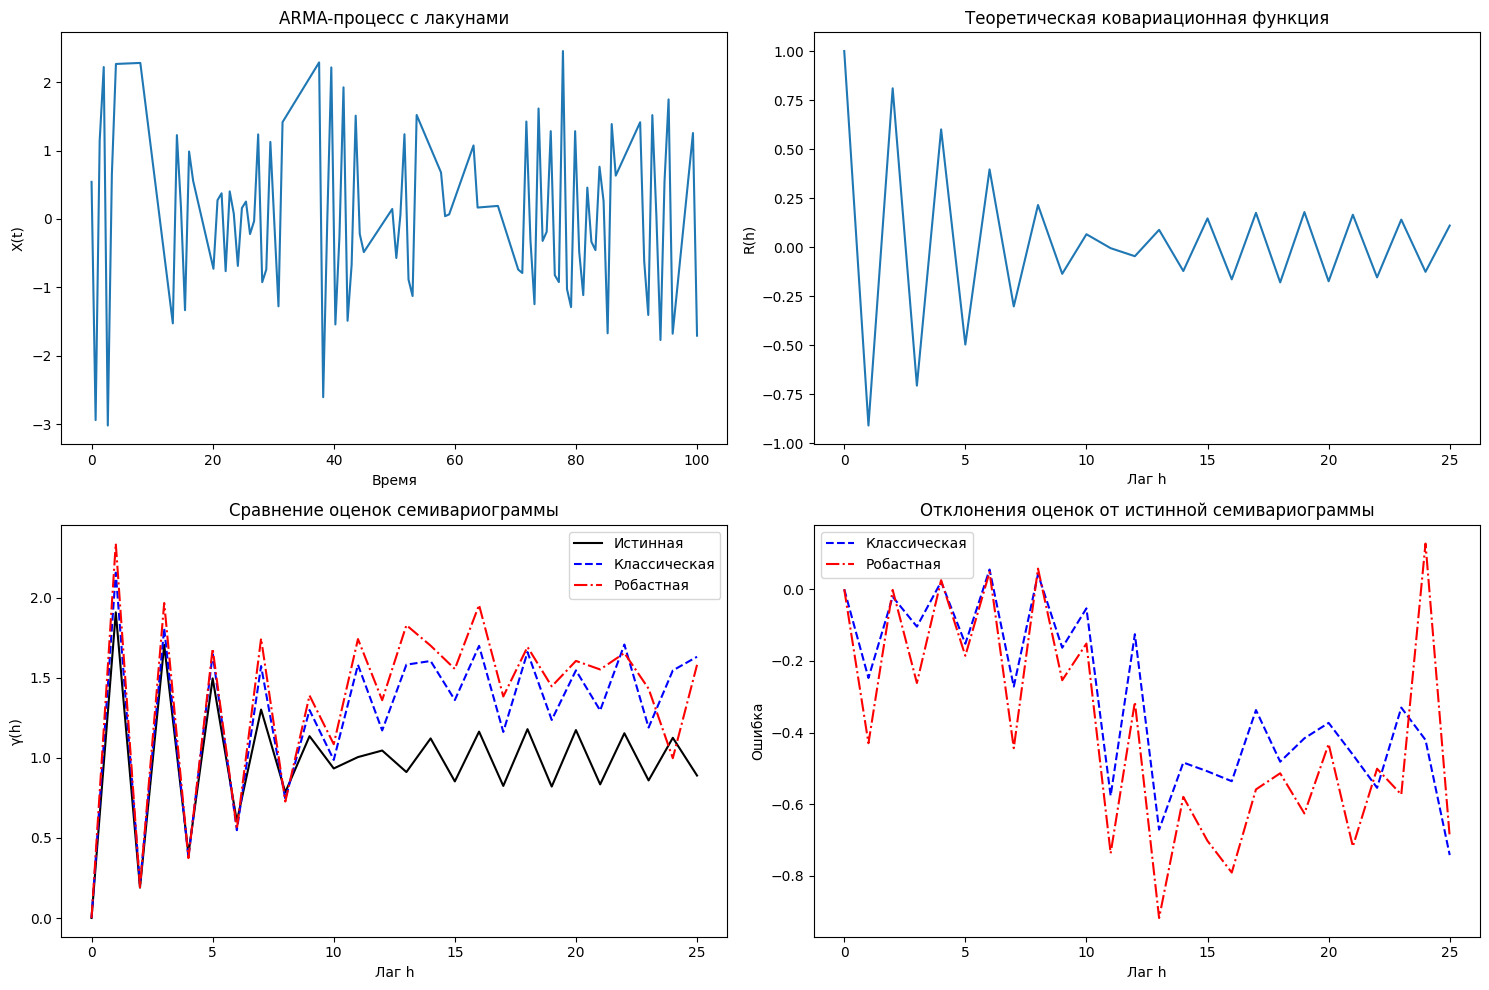

In [4]:
#первая часть в код
import numpy as np
import matplotlib.pyplot as plt

def theoretical_cov(h, D=1.0, alpha=0.15, beta=3.0):
    return D * np.exp(-alpha * np.abs(h)) * np.cos(beta * h)

def true_semivariogram(h, D=1.0, alpha=0.15, beta=3.0):
    return D * (1 - np.exp(-alpha * np.abs(h)) * np.cos(beta * h))

def generate_arma_process(n=150, T=100.0, D=1.0, alpha=0.15, beta=3.0):
    dt = T / n
    gamma = alpha * dt
    gamma0 = beta * dt

    alpha_0 = np.exp(-gamma) * (np.exp(-2*gamma) - 1) * np.cos(gamma0)
    alpha1 = 1 - np.exp(-4*gamma)

    a0 = np.sqrt(D) * alpha
    a1 = np.sqrt(D) * (alpha_0 / alpha)
    b1 = 2 * np.exp(-gamma) * np.cos(gamma0)
    b2 = -np.exp(-2 * gamma)

    np.random.seed(43)
    x = np.random.normal(0, 1, n)

    xi = np.zeros(n)
    xi[0] = a0 * x[0]
    xi[1] = a0 * x[1] + a1 * x[0] + b1 * xi[0]

    for k in range(2, n):
        xi[k] = a0 * x[k] + a1 * x[k-1] + b1 * xi[k-1] + b2 * xi[k-2]

    return xi

#добавление пропусков (лакун) в регулярную сетку
def add_lacunarity(t_regular, n_gaps=15, gap_size=0.03):
    t_irregular = t_regular.copy()
    total_time = t_regular[-1] - t_regular[0]
    gap_size_abs = gap_size * total_time
    
    for _ in range(n_gaps):
        gap_start = np.random.uniform(t_irregular[0], t_irregular[-1] - gap_size_abs)
        mask = (t_irregular < gap_start) | (t_irregular > gap_start + gap_size_abs)
        t_irregular = t_irregular[mask]
    
    return t_irregular

#генерирование гауссовского процесса
def generate_gaussian_process(t_points, D=1.0, alpha=0.15, beta=3.0):
    n = len(t_points)
    cov_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            cov_matrix[i, j] = theoretical_cov(t_points[i] - t_points[j], D, alpha, beta)
    
    return np.random.multivariate_normal(np.zeros(n), cov_matrix)
    
#оценки семивариограммы
def irregular_semivariogram(t, X, h_max, method='classical'):
    n = len(X)
    gamma = np.zeros(h_max + 1)
    counts = np.zeros(h_max + 1)
    
    for i in range(n):
        for j in range(i + 1, n):
            h = int(np.round(np.abs(t[i] - t[j])))
            if h <= h_max:
                if method == 'classical':
                    gamma[h] += (X[i] - X[j])**2
                elif method == 'robust':
                    gamma[h] += np.abs(X[i] - X[j])**0.5
                counts[h] += 1
    
    if method == 'classical':
        with np.errstate(divide='ignore', invalid='ignore'):
            gamma = np.where(counts > 0, gamma / (2 * counts), 0)
    elif method == 'robust':
        for h in range(h_max + 1):
            if counts[h] > 0:
                term = gamma[h] / counts[h]
                denominator = 2 * (0.457 + 0.494/counts[h] + 0.045/counts[h]**2)
                gamma[h] = (term**4) / denominator
            else:
                gamma[h] = 0
    return gamma

# Параметры
np.random.seed(42)
D = 1.0
alpha = 0.085
beta = 3.0
T = 100.0
n = 150
h_max = 25
n_gaps = 15
gap_size = 0.03

t_regular = np.linspace(0, T, n)
X_regular = generate_arma_process(n, T, D, alpha, beta)

t_irregular = add_lacunarity(t_regular, n_gaps, gap_size)
X_irregular = generate_gaussian_process(t_irregular, D, alpha, beta)

#теоретическая семивариограмма
h_values = np.arange(h_max + 1)
true_gamma = np.array([true_semivariogram(h, D, alpha, beta) for h in h_values])

#оценки семивариограммы
gamma_irreg_classic = irregular_semivariogram(t_irregular, X_irregular, h_max, 'classical')
gamma_irreg_robust = irregular_semivariogram(t_irregular, X_irregular, h_max, 'robust')

#аизуализация
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(t_irregular, X_irregular)
plt.title('ARMA-процесс с лакунами')
plt.xlabel('Время')
plt.ylabel('X(t)')

plt.subplot(2, 2, 2)
cov_values = [theoretical_cov(h, D, alpha, beta) for h in h_values]
plt.plot(h_values, cov_values)
plt.title('Теоретическая ковариационная функция')
plt.xlabel('Лаг h')
plt.ylabel('R(h)')

plt.subplot(2, 2, 3)
plt.plot(h_values, true_gamma, 'k-', label='Истинная')
plt.plot(h_values, gamma_irreg_classic, 'b--', label='Классическая')
plt.plot(h_values, gamma_irreg_robust, 'r-.', label='Робастная')
plt.title('Сравнение оценок семивариограммы')
plt.xlabel('Лаг h')
plt.ylabel('γ(h)')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(h_values, true_gamma - gamma_irreg_classic, 'b--', label='Классическая')
plt.plot(h_values, true_gamma - gamma_irreg_robust, 'r-.', label='Робастная')
plt.title('Отклонения оценок от истинной семивариограммы')
plt.xlabel('Лаг h')
plt.ylabel('Ошибка')
plt.legend()

plt.tight_layout()
plt.show()


Результаты для нерегулярной сетки:
+-------------------------+------------+------------+------------+------------+------------+------------+
|       Исходное n        |          h=1.0          |          h=7.0          |         h=15.0          |
+-------------------------+------------+------------+------------+------------+------------+------------+
|                         |  Classic   |   Robust   |  Classic   |   Robust   |  Classic   |   Robust   |
+-------------------------+------------+------------+------------+------------+------------+------------+
|           25            |  0.139925  |  0.113484  |  0.068693  |  0.056239  |  0.002147  |  0.001827  |
+-------------------------+------------+------------+------------+------------+------------+------------+
|           50            |  0.053558  |  0.046690  |  0.014094  |  0.012455  |  0.001612  |  0.001427  |
+-------------------------+------------+------------+------------+------------+------------+------------+
|         

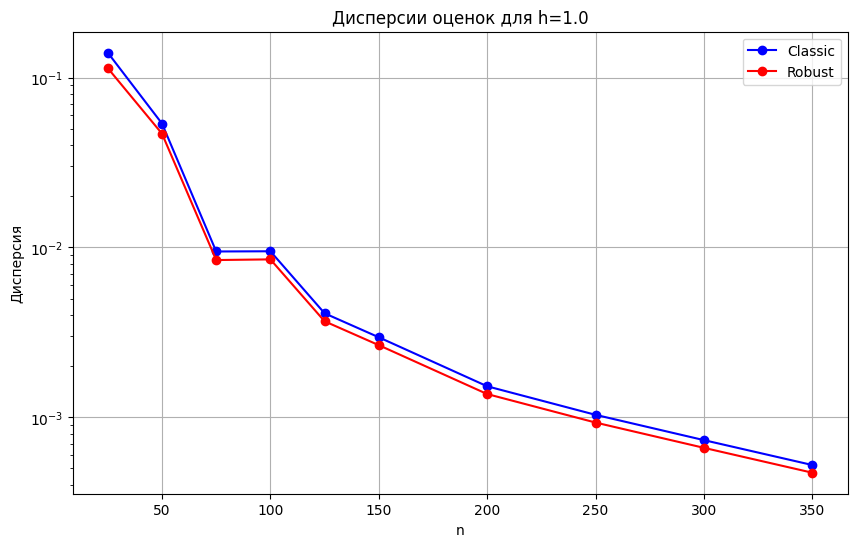

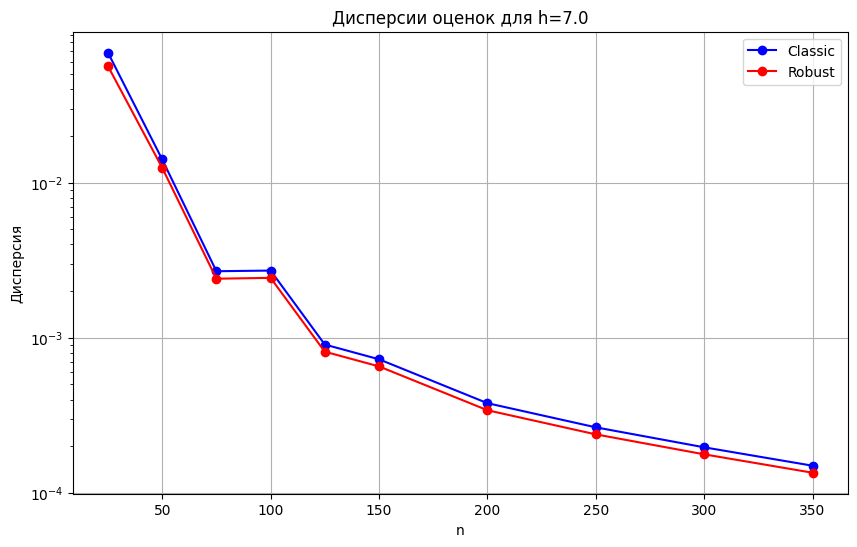

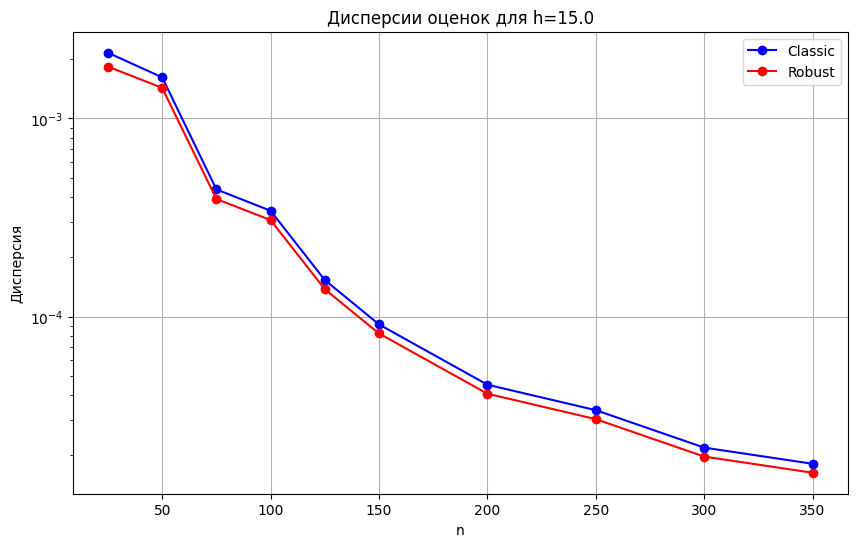

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma

# 1. Функции для моделирования процесса и вычисления семивариограммы
def theoretical_cov(h, D=1.0, alpha=0.15, beta=3.0):
    return D * np.exp(-alpha * np.abs(h)) * np.cos(beta * h)

def true_semivariogram(h, D=1.0, alpha=0.15, beta=3.0):
    return D * (1 - np.exp(-alpha * np.abs(h)) * np.cos(beta * h))

def generate_arma_process(n=150, T=100.0, D=1.0, alpha=0.15, beta=3.0):
    dt = T / n
    gamma_val = alpha * dt
    gamma0 = beta * dt

    alpha0 = np.exp(-gamma_val) * (np.exp(-2*gamma_val) - 1) * np.cos(gamma0)
    a0 = np.sqrt(D) * alpha
    a1 = np.sqrt(D) * (alpha0 / alpha)
    b1 = 2 * np.exp(-gamma_val) * np.cos(gamma0)
    b2 = -np.exp(-2 * gamma_val)

    np.random.seed(43)
    x = np.random.normal(0, 1, n)

    xi = np.zeros(n)
    xi[0] = a0 * x[0]
    xi[1] = a0 * x[1] + a1 * x[0] + b1 * xi[0]
    for k in range(2, n):
        xi[k] = a0 * x[k] + a1 * x[k-1] + b1 * xi[k-1] + b2 * xi[k-2]
    
    return xi

def add_lacunarity(t_regular, n_gaps=15, gap_size=0.03):
    t_irregular = t_regular.copy()
    total_time = t_regular[-1] - t_regular[0]
    gap_size_abs = gap_size * total_time
    
    for _ in range(n_gaps):
        gap_start = np.random.uniform(t_irregular[0], t_irregular[-1] - gap_size_abs)
        mask = (t_irregular < gap_start) | (t_irregular > gap_start + gap_size_abs)
        t_irregular = t_irregular[mask]
    
    return t_irregular

def generate_gaussian_process(t_points, D=1.0, alpha=0.15, beta=3.0):
    n = len(t_points)
    cov_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            cov_matrix[i, j] = theoretical_cov(t_points[i] - t_points[j], D, alpha, beta)
    
    return np.random.multivariate_normal(np.zeros(n), cov_matrix)

# 2. Функции для вычисления дисперсий оценок
def classic_variance_irregular(t_points, gamma_func, h, tol=5.0):
    pairs = []
    n = len(t_points)
    
    # Находим пары с расстоянием h±tol
    for i in range(n):
        for j in range(i+1, n):
            if abs(abs(t_points[j] - t_points[i]) - h) < tol:
                pairs.append((i, j))
    
    m = len(pairs)
    if m < 2:  # Минимум 2 пары для оценки
        return np.nan
    
    total = 0.0
    for (i, j) in pairs:
        delta = abs(t_points[j] - t_points[i])
        term = gamma_func(delta + h) + gamma_func(abs(delta - h)) - 2*gamma_func(delta)
        total += term**2
    
    return total / (2 * m**2)

def robust_variance_irregular(t_points, gamma_func, h, tol=5.0):
    pairs = []
    n = len(t_points)
    
    for i in range(n):
        for j in range(i+1, n):
            if abs(abs(t_points[j] - t_points[i]) - h) < tol:
                pairs.append((i, j))
    
    m = len(pairs)
    if m < 2:
        return np.nan
    
    gamma_34 = gamma(3/4)
    pi = np.pi
    C1 = (pi**(-0.5) - gamma_34**2/pi) * gamma_34**6 / pi**3
    denominator = (0.457 + 0.494/m + 0.045/m**2)**2
    
    total = 0.0
    for (i, j) in pairs:
        delta = abs(t_points[j] - t_points[i])
        term = gamma_func(delta + h) + gamma_func(abs(delta - h)) - 2*gamma_func(delta)
        total += term**2
    
    return (10 * C1 * total) / (m**2 * denominator)

# Параметры
n_values = [25, 50, 75, 100, 125, 150, 200, 250, 300, 350]
h_values = [1.0, 7.0, 15.0]
D = 1.0
alpha = 0.085
beta = 3.0
T = 100.0
tol = 0.5*h

results = {}

for h in h_values:
    classic_vars = []
    robust_vars = []
    
    for n in n_values:
        t_regular = np.linspace(0, T, n)
        t_irregular = add_lacunarity(t_regular, n_gaps=15, gap_size=0.03)
        
        gamma_f = lambda x: true_semivariogram(x, D, alpha, beta)
        
        classic_var = classic_variance_irregular(t_irregular, gamma_f, h, tol)
        robust_var = robust_variance_irregular(t_irregular, gamma_f, h, tol)
        
        classic_vars.append(classic_var)
        robust_vars.append(robust_var)
    
    results[h] = {'D_classic': classic_vars, 'D_robust': robust_vars}

#Визуализация
def make_line(h_values, n_width=25, d_width=12):
    line = "+" + "-" * n_width + "+"
    for _ in h_values:
        line += "-" * d_width + "+" + "-" * d_width + "+"
    return line

print("\nРезультаты для нерегулярной сетки:")
print(make_line(h_values))
header = f"|{'Исходное n':^{25}}|"
for h in h_values:
    header += f"{f'h={h}':^{25}}|"
print(header)

print(make_line(h_values))
subheader = f"|{' ' * 25}|"
for _ in h_values:
    subheader += f"{'Classic':^{12}}|{'Robust':^{12}}|"
print(subheader)

print(make_line(h_values))
for i, n in enumerate(n_values):
    row = f"|{n:^{25}}|"
    for h in h_values:
        classic = f"{results[h]['D_classic'][i]:.6f}" if not np.isnan(results[h]['D_classic'][i]) else "NaN"
        robust = f"{results[h]['D_robust'][i]:.6f}" if not np.isnan(results[h]['D_robust'][i]) else "NaN"
        row += f"{classic:^{12}}|{robust:^{12}}|"
    print(row)
    print(make_line(h_values))

for h in h_values:
    plt.figure(figsize=(10, 6))
    
    valid_n = [n for n, v in zip(n_values, results[h]['D_classic']) if not np.isnan(v)]
    classic_vals = [v for v in results[h]['D_classic'] if not np.isnan(v)]
    robust_vals = [v for v in results[h]['D_robust'] if not np.isnan(v)]
    
    plt.plot(valid_n, classic_vals, 'bo-', label='Classic')
    plt.plot(valid_n, robust_vals, 'ro-', label='Robust')
    
    plt.title(f'Дисперсии оценок для h={h}')
    plt.xlabel('n')
    plt.ylabel('Дисперсия')
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    plt.show()